In [1]:
import cv2

# Load the video
cap = cv2.VideoCapture('output.avi')

# Calculate the frame number to capture
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_to_capture = total_frames//1.2

# Set the frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_capture)

# Read the frame
ret, frame = cap.read()
if ret:
    cv2.imwrite('selected_frame.jpg', frame)
    cv2.imshow('Selected Frame', frame)
    cv2.waitKey(0)

# Clean up
cap.release()
cv2.destroyAllWindows()


In [1]:
import cv2

# Global variables
refPt = []  # To store rectangle points
cropping = False

def click_and_crop(event, x, y, flags, param):
    # Access global variables
    global refPt, cropping, image, clone

    # If the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True

    # Check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # Record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False

        # Draw a rectangle around the region of interest on the display image
        cv2.rectangle(clone, refPt[0], refPt[1], (0, 255, 0), 2)
        cv2.imshow("image", clone)

        # Extract the ROI from the original image using the refPt coordinates
        roi = image[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]

        # Save the ROI
        cv2.imwrite('roi.jpg', roi)

        # Close all open windows
        cv2.destroyAllWindows()

# Load the image and create a clone for drawing
image = cv2.imread('selected_frame.jpg')
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)

# Display the image and wait for a keypress or ROI selection
while True:
    # Display the clone image where the rectangle is drawn
    cv2.imshow("image", clone)
    key = cv2.waitKey(1) & 0xFF

    # If the 'q' key is pressed, break from the loop
    if key == ord('q'):
        break

# Close all open windows if 'q' was pressed
cv2.destroyAllWindows()


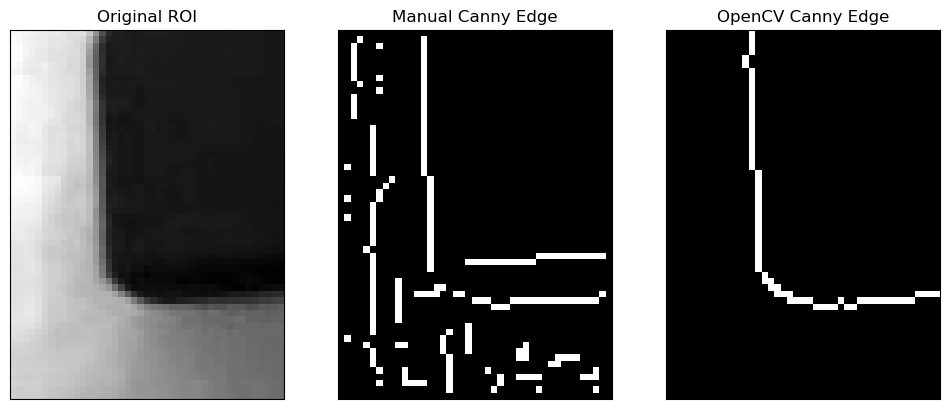

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_blur(image, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def sobel_filters(img):
    Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = np.sqrt(Gx ** 2 + Gy ** 2)
    direction = np.arctan2(Gy, Gx)
    return magnitude, direction

def non_maximum_suppression(magnitude, direction):
    M, N = magnitude.shape
    Z = np.zeros((M,N), dtype=np.float32)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255
            # Check the angle and compare with the neighbors
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                Z[i,j] = magnitude[i,j]
            else:
                Z[i,j] = 0
    return Z

def threshold(img, lowThreshold, highThreshold):
    strong = 255
    weak = 75
    res = np.zeros_like(img)
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return res, weak, strong

def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

# Load image and convert to grayscale
image = cv2.imread('roi.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur
blurred_image = gaussian_blur(image)

# Manual Canny Edge Detection
magnitude, direction = sobel_filters(blurred_image)
thin_edges = non_maximum_suppression(magnitude, direction)
thresholded, weak, strong = threshold(thin_edges, 50, 150)
manual_canny = hysteresis(thresholded, weak, strong)

# OpenCV Canny Edge Detection
opencv_canny = cv2.Canny(image, 50, 150)

# Plotting the results using matplotlib
plt.figure(figsize=(12, 8))
plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title('Original ROI')
plt.xticks([]), plt.yticks([])  # Hide tick values on X and Y axis
plt.subplot(132), plt.imshow(manual_canny, cmap='gray'), plt.title('Manual Canny Edge')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(opencv_canny, cmap='gray'), plt.title('OpenCV Canny Edge')
plt.xticks([]), plt.yticks([])
plt.show()
